<a href="https://colab.research.google.com/github/mostafa-ja/Machine-Learning-fall2023/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Answer these questions about Classificaton
1. Why would you want to use: <br />
a. Ridge regression instead of plain linear regression (i.e., without any
regularization)?<br />
b. Lasso instead of ridge regression?<br />
c. Elastic net instead of lasso regression?

A model with some regularization typically performs better than a model
without any regularization, so you should generally prefer Ridge Regression
over plain Linear Regression.

• Lasso Regression uses an ℓ1 penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.

• Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you just want Lasso without the erratic behavior, you can just use Elastic Net with an l1_ratio close to 1.



2. Suppose you want to classify pictures as outdoor/indoor and
daytime/nighttime. Should you implement two logistic regression
classifiers or one softmax regression classifier?

If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.

In [1]:
# lets import the essential packages we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Sign Language Classification

The American Sign Language MNIST Dataset we are going to use is obtained from [Kaggle](https://www.kaggle.com/datamunge/sign-language-mnist). This dataset is much like the original MNIST dataset. Each training and test case consists of a numerical label (0–25) with a one-to-one correspondence to the English alphabet (0 corresponds to A) and a grayscale 28x28 pixel image with values ranging from 0–255. However, there is no label correspondence to the letter J (9) and Z (25) due to the motion required to symbolize those letters. The number of testing and training cases in this dataset are much lower compared to the orginal MNIST dataset since there are only 27,455 training cases and 7,172 tests cases in this dataset.

<img src="images/sign_language.png" width=700 height=700 />

In this problem we are going to implement a simple multi-class classification model to classify each image to its desired label. For downloading the dataset, use this [link](https://www.kaggle.com/datamunge/sign-language-mnist).

**Note:** You may need to create a new account in Kaggle if you have not registered yet. Then put the downloaded directory in the `dataset/` folder with the name of : `sign-dataset/`

In [2]:
#import kaggle.json
import gdown
download_link = 'https://drive.google.com/uc?id=18bN4Mot3QMrtnaU-DWEcxVYuH3b9Un3Q'
output_filepath = '/content/'
gdown.download(download_link, output_filepath)

Downloading...
From: https://drive.google.com/uc?id=18bN4Mot3QMrtnaU-DWEcxVYuH3b9Un3Q
To: /content/kaggle.json
100%|██████████| 69.0/69.0 [00:00<00:00, 151kB/s]


'/content/kaggle.json'

In [3]:
#upload data from kaggle website

# Install Kaggle API.
!pip install kaggle
# Run the following code to configure the path to “kaggle.json”
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
#download the dataset
!kaggle datasets download -d datamunge/sign-language-mnist
#unzip the dataset
!mkdir -p /content/datasets/sign-dataset/
!unzip '/content/sign-language-mnist.zip' -d "/content/datasets/sign-dataset/"

 88% 55.0M/62.6M [00:00<00:00, 155MB/s]
100% 62.6M/62.6M [00:00<00:00, 146MB/s]
Archive:  /content/sign-language-mnist.zip
  inflating: /content/datasets/sign-dataset/amer_sign2.png  
  inflating: /content/datasets/sign-dataset/amer_sign3.png  
  inflating: /content/datasets/sign-dataset/american_sign_language.PNG  
  inflating: /content/datasets/sign-dataset/sign_mnist_test.csv  
  inflating: /content/datasets/sign-dataset/sign_mnist_test/sign_mnist_test.csv  
  inflating: /content/datasets/sign-dataset/sign_mnist_train.csv  
  inflating: /content/datasets/sign-dataset/sign_mnist_train/sign_mnist_train.csv  


In [4]:
import os
import string

train_dataset = pd.read_csv('/content/datasets/sign-dataset/sign_mnist_train/sign_mnist_train.csv')
test_dataset = pd.read_csv('/content/datasets/sign-dataset/sign_mnist_test/sign_mnist_test.csv')
num_rows = train_dataset.shape[0]
# To map each label number to its corresponding letter
letters = dict(enumerate(string.ascii_uppercase))

In [5]:
letters

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

In [6]:
num_rows

27455

Now it is the time foe data exploration! The first few rows of the training datast are shown below:

In [ ]:
train_dataset.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


We need to separate the pixel values and the label from each other in order for us to load and access it separately. A function was constructed to split the training and testing dataset to separate the labels from the pixel values.

In [ ]:
def dataframe_to_array(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1.iloc[:, 1:].to_numpy()
    targets_array = dataframe1['label'].to_numpy()
    return inputs_array, targets_array

In [ ]:
X_train, y_train = dataframe_to_array(train_dataset)
X_test, y_test = dataframe_to_array(test_dataset)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(27455, 784) (27455,)
(7172, 784) (7172,)


Let’s look at the first row of the training dataset. We also need to reshape the array to (28x28) since the initial shape is just a row array.

Letter:  D


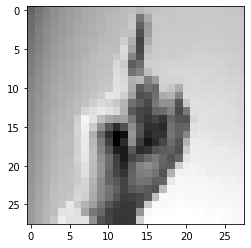

In [ ]:
pic1 = np.reshape(X_train[0], (28, 28))
plt.imshow(pic1, cmap = "gray")
print("Letter: ", letters[y_train[0].item()])

As expected, the letter in the hand image is D. However, it is evident that the image is not clear due to its small resolution. This may affect the accuracy of our model and the implementation of the model in a much larger scale.

The training and testing input arrays are converted to continuous float values since it allows our model for a more precise learning as compared to discrete values. On the other hand, the training and testing labels are converted to long integers since the output of the model are indices to be used in accessing probability values.

## Q1. Implement `SimpleLogisticRegression` class. (25 points)

You are free to search on the internet about implementing a Logistic Regression model using `sklearn.linear_model.LogisticRegression`.

In [ ]:
from sklearn.linear_model import LogisticRegression

############# Your code here ############

#########################################

## Q2. Multi-label classification metrics. (10 points)

Search on the web and find **two** best metrics for multi-label classification. Write about how it works and why we use them. Then, implement it using `sklearn.metrics`

In [ ]:
############# Your code here ############

#########################################

# 3. Submission

Please read the notes here carefully:

1. The more beautiful and insightfull your plots and diagrams are, the more points you get. So please take your time and concentration to prepare a good report with nice diagrams.

2. The file you upload must be named as `[Student ID]-[Your name].zip` and it must contain **only 1 file**:

  - `Linear_and_Logistic_Regression.ipynb`
  
4. **Important Note**: The outputs of the code blocks must be remained in your notebook, otherwise, you definitly lose all the points of that